In [2]:
import torch

In [3]:
words = open('names.txt', 'r').read().splitlines()

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [64]:
# compute dataset

X, Y = [], []

block_size = 3

#  . . . -> e

for w in words:
  context = [0] * block_size

  for c in list(w + '.'):

    X.append(context[:])
    Y.append(stoi[c])

    # print(f'{" ".join([itos[x] for x in context[:]])} -> {c}')

    context.append(stoi[c])
    context = context[1:]

X = torch.tensor(X)
Y = torch.tensor(Y)


In [6]:
C = torch.randn(27, 2)
C[5]

tensor([-0.4563, -0.6563])

In [7]:
emb = C[X]

In [8]:
W1 = torch.randn(6, 100)
B1 = torch.randn(100)

In [9]:
h = torch.tanh(emb.view(-1, 6) @ W1 + B1)
h

tensor([[ 0.8499,  1.0000, -0.9010,  ..., -0.9989,  0.9962,  0.8905],
        [ 0.2800,  0.9999, -0.0691,  ..., -0.9775,  0.9933,  0.9083],
        [ 0.7849,  0.9996,  0.8385,  ..., -0.8625,  0.9743,  0.8264],
        ...,
        [-0.0029, -0.6750, -0.9984,  ...,  0.9567, -0.9184, -0.9999],
        [ 0.9943, -0.9968, -0.2121,  ...,  0.9998, -0.3050, -0.9878],
        [-0.9996,  0.9997, -0.1072,  ..., -0.9935,  0.5675, -0.9997]])

In [10]:
W2 = torch.randn(100, 27)
B2 = torch.randn(27)

In [32]:
logits = h @ W2 + B2
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)
probs[0].sum()

tensor(1.)

In [156]:
# make it more respectable

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(27, 2, generator=g)
W1 = torch.randn(6, 100, generator=g)
B1 = torch.randn(100, generator=g)
W2 = torch.randn(100, 27, generator=g)
B2 = torch.randn(27, generator=g)
parameters = [C, W1, B1, W2, B2]

for p in parameters:
  p.requires_grad = True


In [157]:
inc_exp = torch.linspace(-3, 0, 1000)
inc_steps = 10**inc_exp

In [158]:
ix = []
iy = []

for i in range(1000):
  batch_indices = torch.randint(0, X.shape[0], (32,))

  # forward pass
  emb = C[X[batch_indices]]
  h = torch.tanh(emb.view(-1, 6) @ W1 + B1)
  logits = h @ W2 + B2
  loss = torch.nn.functional.cross_entropy(logits, Y[batch_indices])

  # backwards
  for p in parameters:
    p.grad = None

  loss.backward()


  # optimization
  lr = inc_steps[i]
  # lr = 0.01

  for p in parameters:
    p.data += -lr * p.grad

  # stats
  ix.append(lr)
  iy.append(loss.item())

# print(loss.item())

In [159]:

emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + B1)
logits = h @ W2 + B2
loss = torch.nn.functional.cross_entropy(logits, Y)

print(loss.item())


6.997771739959717


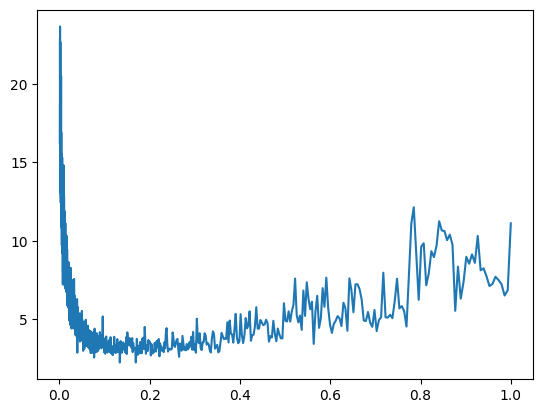

In [160]:
import matplotlib.pyplot as plt
plt.plot(ix, iy)
